# Building a Similarity Comparison Set, Revisited

Goal: construct a set of molecular pairs that can be used to compare similarity methods to each other.

The earlier version of this notebook (http://rdkit.blogspot.ch/2013/10/building-similarity-comparison-set-goal.html or https://github.com/greglandrum/rdkit_blog/blob/master/notebooks/Building%20A%20Similarity%20Comparison%20Set.ipynb)included a number of molecules that have counterions (from salts). Because this isn't really what we're interested in (and because the single-atom fragments that make up many salts triggered a bug in the RDKit's Morgan fingerprint implementation), I repeat the analysis here and restrict it to single-fragment molecules (those that do not include a `.` in the SMILES).

The other big difference from the previous post is that an updated version of ChEMBL is used; this time it's ChEMBL21.

I want to start with molecules that have some connection to each other, so I will pick pairs that have a baseline similarity: a Tanimoto similarity using count based Morgan0 fingerprints of at least 0.7. I also create a second set of somewhat more closely related molecules where the baseline similarity is 0.6 with a Morgan1 fingerprint. Both thresholds were selected empirically.

**Note:** this notebook and the data it uses/generates can be found in the github repo: https://github.com/greglandrum/rdkit_blog

I'm going to use ChEMBL as my data source, so I'll start by adding a table with Morgan0 fingerprints that only contains molecules with molwt<=600 and a single fragment (we recognize this because there is no '.' in the SMILES):

    chembl_21=# select molregno,morgan_fp(m,0) mfp0 into table rdk.tfps_smaller from rdk.mols 
    join compound_properties using (molregno) 
    join compound_structures using (molregno) 
    where mw_monoisotopic<=600 and canonical_smiles not like '%.%';
    SELECT 1372487
    chembl_21=# create index sfps_mfp0_idx on rdk.tfps_smaller using gist(mfp0);
    CREATE INDEX
   

And now I'll build the set of pairs using Python. This is definitely doable in SQL, but my SQL-fu isn't that strong.

Start by getting a set of 35K random small molecules with MW<=600:

In [28]:
from rdkit import Chem
from rdkit import rdBase
print(rdBase.rdkitVersion)
import time
print(time.asctime())

2016.03.1
Thu Apr 21 11:41:19 2016


In [1]:
import psycopg2
cn = psycopg2.connect(dbname='chembl_21')
curs = cn.cursor()
curs.execute('select molregno,m from rdk.mols join rdk.tfps_smaller using (molregno) order by random() limit 35000')
qs = curs.fetchall()

And now find one neighbor for 25K of those from the mfp0 table of smallish molecules:

In [2]:
cn.rollback()
curs.execute('set rdkit.tanimoto_threshold=0.7')

keep=[]
for i,row in enumerate(qs):
    curs.execute('select molregno,m from rdk.mols join (select molregno from rdk.tfps_smaller where mfp0%%morgan_fp(%s,0) '
                 'and molregno!=%s limit 1) t2 using (molregno)',(row[1],row[0]))
    d = curs.fetchone()
    if not d: continue
    keep.append((row[0],row[1],d[0],d[1]))
    if len(keep)==25000: break
    if not i%1000: print('Done: %d'%i)


Done: 0
Done: 1000
Done: 2000
Done: 3000
Done: 4000
Done: 5000
Done: 6000
Done: 7000
Done: 8000
Done: 9000
Done: 10000
Done: 11000
Done: 12000
Done: 13000
Done: 14000
Done: 15000
Done: 16000
Done: 17000
Done: 18000
Done: 19000
Done: 20000
Done: 21000
Done: 22000
Done: 23000
Done: 24000
Done: 25000


Finally, write those out to a file so that we can use them elsewhere:

In [3]:
import gzip
outf = gzip.open('../data/chembl21_25K.pairs.txt.gz','wb+')
for idx1,smi1,idx2,smi2 in keep: outf.write(('%d %s %d %s\n'%(idx1,smi1,idx2,smi2)).encode('UTF-8'))
outf=None


# Early analysis of the data

Start by loading the pairs from the file we saved and creating RDKit molecules from them

In [4]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
from rdkit.Chem import Draw
import gzip


In [5]:
rows=[]
for row in gzip.open('../data/chembl21_25K.pairs.txt.gz').readlines():
    row = row.split()
    row[1] = Chem.MolFromSmiles(row[1])
    row[3] = Chem.MolFromSmiles(row[3])
    rows.append(row)

Look at some pairs:

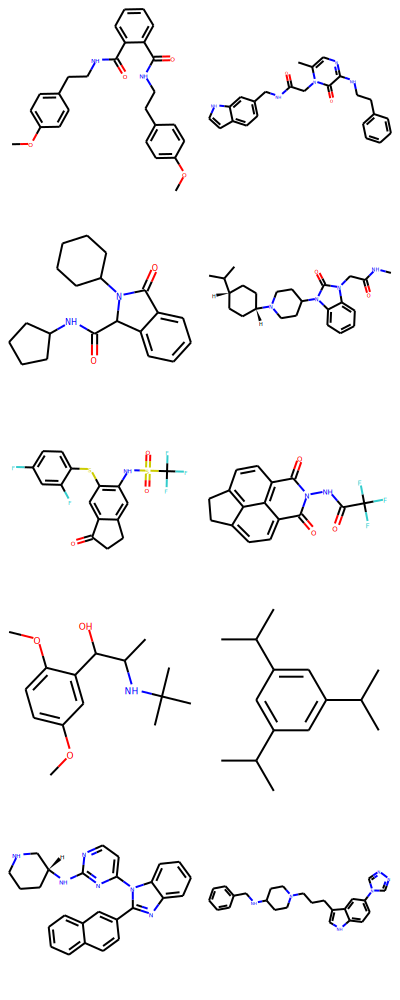

In [6]:
t = []
for x in rows[:5]:
    t.append(x[1])
    t.append(x[3])
    
Draw.MolsToGridImage(t,molsPerRow=2)

## Take a look at property distributions.

Each plot below contains two histograms. The one in blue is for the first set of molecules, the one in green is for the neighbor molecules.

In [7]:
from rdkit.Chem import Descriptors

In [8]:
mws = [(Descriptors.MolWt(x[1]),Descriptors.MolWt(x[3])) for x in rows]
nrots = [(Descriptors.NumRotatableBonds(x[1]),Descriptors.NumRotatableBonds(x[3])) for x in rows]
logps = [(Descriptors.MolLogP(x[1]),Descriptors.MolLogP(x[3])) for x in rows]

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


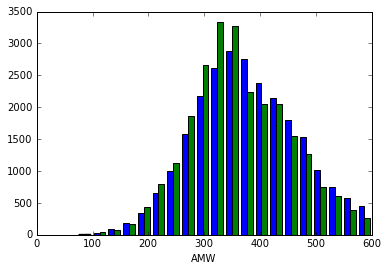

In [10]:
_=hist(([x for x,y in mws],[y for x,y in mws]),bins=20,histtype='bar')
xlabel('AMW')

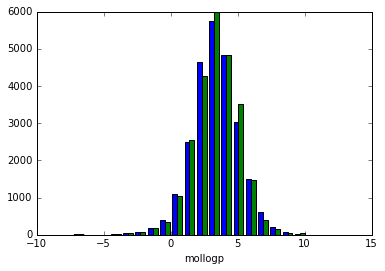

In [11]:
_=hist(([x for x,y in logps],[y for x,y in logps]),bins=20,histtype='bar')
xlabel('mollogp')

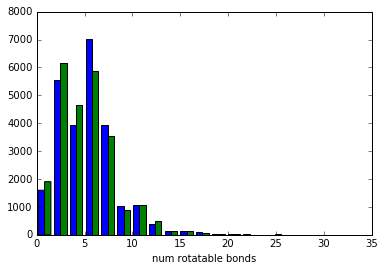

In [12]:
_=hist(([x for x,y in nrots],[y for x,y in nrots]),bins=20,histtype='bar')
xlabel('num rotatable bonds')

and a histogram of the similarities we used to construct the set

In [13]:
from rdkit import DataStructs
from rdkit.Chem import rdMolDescriptors
sims = [DataStructs.TanimotoSimilarity(rdMolDescriptors.GetMorganFingerprint(x[1],0),rdMolDescriptors.GetMorganFingerprint(x[3],0)) for x in rows]

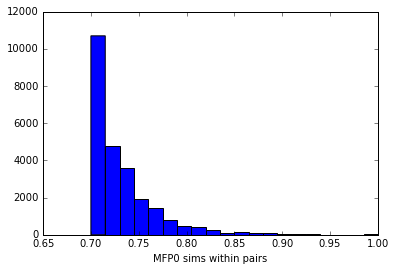

In [14]:
_=hist(sims,bins=20)
xlabel('MFP0 sims within pairs')

compare to MFP2 similarity (more on this in a later post)

In [15]:
sims2 = [DataStructs.TanimotoSimilarity(rdMolDescriptors.GetMorganFingerprint(x[1],2),rdMolDescriptors.GetMorganFingerprint(x[3],2)) for x in rows]

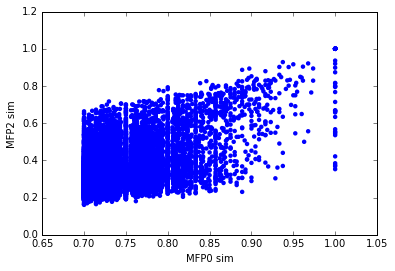

In [16]:
_=scatter(sims,sims2,marker='o',edgecolors='none')
xlabel('MFP0 sim')
ylabel('MFP2 sim')

Look at the distribution of MFP0 similarities in random molecule pairs (more on this in a later post) 

In [17]:
import random
idxs = list(range(len(rows)))
random.shuffle(idxs)
ms1 = [x[1] for x in rows]
ms2 = [rows[x][3] for x in idxs]
sims = [DataStructs.TanimotoSimilarity(rdMolDescriptors.GetMorganFingerprint(x,0),rdMolDescriptors.GetMorganFingerprint(y,0)) for x,y in zip(ms1,ms2)]

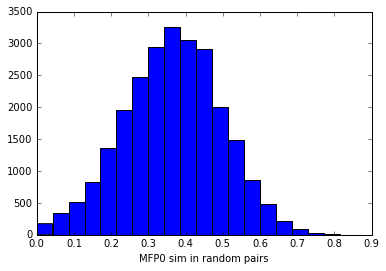

In [18]:
_=hist(sims,bins=20)
xlabel('MFP0 sim in random pairs')

In [19]:
cn = None
curs=None

# Try molecules that are a bit more similar.
Use a similarity threshold for the pairs using MFP1 bits.

As above, start by adding a table with Morgan1 fingerprints for the smaller molecules:

    chembl_21=# select molregno,morgan_fp(m,1) mfp1 into table rdk.tfps1_smaller from rdk.mols 
    join compound_properties using (molregno) 
    join compound_structures using (molregno) 
    where mw_monoisotopic<=600 and canonical_smiles not like '%.%';
    SELECT 1372487
    chembl_21=# create index sfps_mfp1_idx on rdk.tfps1_smaller using gist(mfp1);
    CREATE INDEX
   

In [20]:
import psycopg2
cn = psycopg2.connect(dbname='chembl_21')
curs = cn.cursor()
curs.execute('select molregno,m from rdk.mols join rdk.tfps1_smaller using (molregno) order by random() limit 35000')
qs = curs.fetchall()


And loop to find the pairs:

In [21]:
cn.rollback()
curs.execute('set rdkit.tanimoto_threshold=0.6')

keep=[]
for i,row in enumerate(qs):
    curs.execute('select molregno,m from rdk.mols join (select molregno from rdk.tfps1_smaller where mfp1%%morgan_fp(%s,1) '
                 'and molregno!=%s limit 1) t2 using (molregno)',(row[1],row[0]))
    d = curs.fetchone()
    if not d: continue
    keep.append((row[0],row[1],d[0],d[1]))
    if len(keep)==25000: break
    if not i%1000: print('Done: %d'%i)


Done: 0
Done: 1000
Done: 2000
Done: 3000
Done: 4000
Done: 5000
Done: 6000
Done: 7000
Done: 8000
Done: 9000
Done: 10000
Done: 11000
Done: 12000
Done: 13000
Done: 14000
Done: 15000
Done: 16000
Done: 17000
Done: 18000
Done: 19000
Done: 20000
Done: 21000
Done: 22000
Done: 23000
Done: 24000


In [22]:
import gzip
outf = gzip.open('../data/chembl21_25K.mfp1.pairs.txt.gz','wb+')
for idx1,smi1,idx2,smi2 in keep: outf.write(('%d %s %d %s\n'%(idx1,smi1,idx2,smi2)).encode('UTF-8'))
outf=None


In [26]:
print(len(keep))

25000


In [23]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
from rdkit.Chem import Draw
import gzip


In [24]:
rows=[]
for row in gzip.open('../data/chembl21_25K.mfp1.pairs.txt.gz').readlines():
    row = row.split()
    row[1] = Chem.MolFromSmiles(row[1])
    row[3] = Chem.MolFromSmiles(row[3])
    rows.append(row)
    if len(rows)>100: break # we aren't going to use all the pairs, so there's no sense in reading them all in

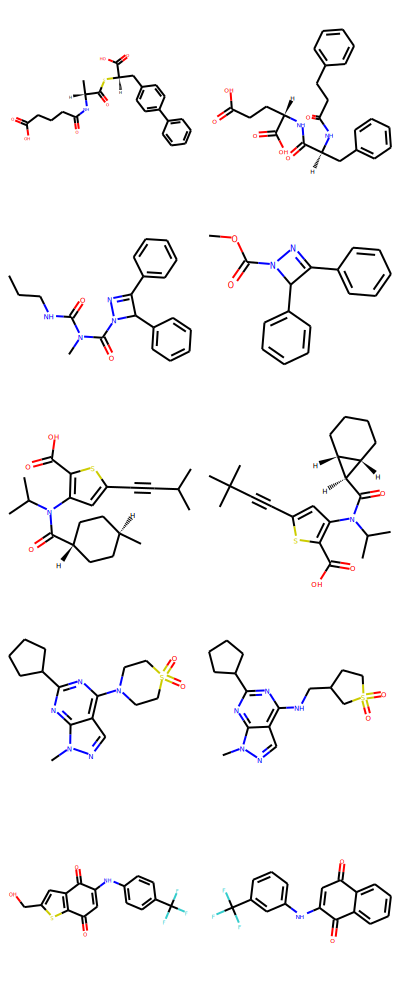

In [25]:
t = []
for x in rows[:5]:
    t.append(x[1])
    t.append(x[3])
    
Draw.MolsToGridImage(t,molsPerRow=2)

I won't repeat the property analysis for this set. These pairs will also be useful later though. 